**RNN과 CNN을 사용해 시퀀스 처리하기**

# 설정

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import sys
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt

# 코랩에서 실행되는 노트북인가?
IS_COLAB = 'google.colab' in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print('감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.')
    if IS_COLAB:
        print('런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.')

# 깔끔한 그래프 출력을 위해
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, f'{fig_id}.{fig_extension}')
    print(f'그림 저장 {fig_id}')
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

# 기본적인 RNN

## 데이터셋 생성

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # 웨이브 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + 웨이브 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # + 잡음
    return series[..., np.newaxis].astype(np.float32)

In [3]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, n_steps]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, n_steps]
X_test, y_test = series[9000:, :n_steps], series[9000:, n_steps]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

그림 저장 time_series_plot


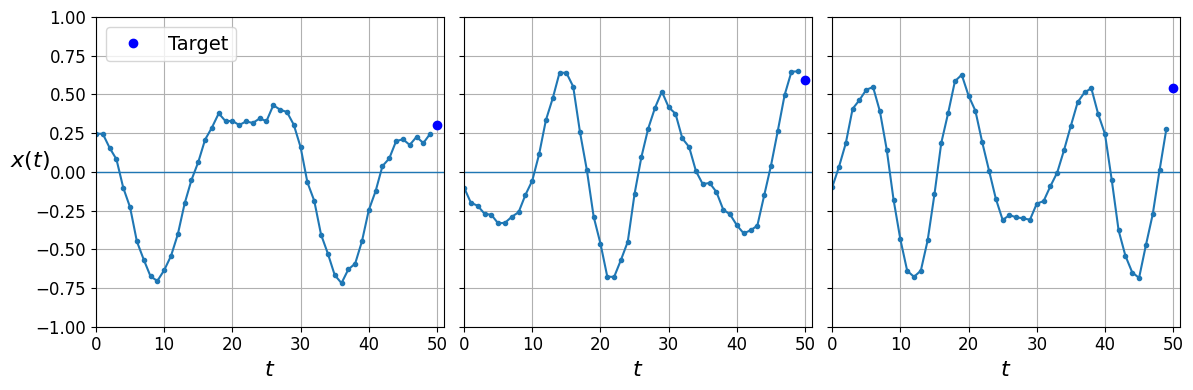

In [5]:
def plot_series(series, y=None, y_pred=None, x_label='$t$', y_label='$x(t)$', legend=True):
    plt.plot(series, '.-')
    if y is not None:
        plt.plot(n_steps, y, 'bo', label='Target')
    if y_pred is not None:
        plt.plot(n_steps, y_pred, 'rx', markersize=10, label='Prediction')
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc='upper left')


fig, axes = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0], y_label=('$x(t)$' if col == 0 else None), legend=(col == 0))
save_fig('time_series_plot')
plt.show()

**노트**: 이 노트북에서 파란 점은 타깃을 나타내고 빨강 X 표시는 예측을 나타낸다.

## 기준 성능 계산하기

단순한 예측 (마지막 관측값을 사용해 예측한다):

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020675158

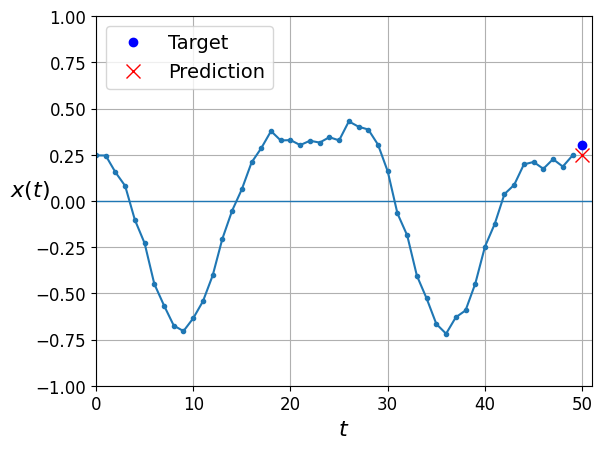

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

선형 예측:

In [8]:
model = keras.models.Sequential([keras.layers.Flatten(input_shape=[50, 1]), keras.layers.Dense(1)])
model.compile('adam', 'mse')
# history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid))

219/219 [==============================] - 2s 3ms/step - loss: 0.0751 - val_loss: 0.0338


In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0338


0.03384421020746231

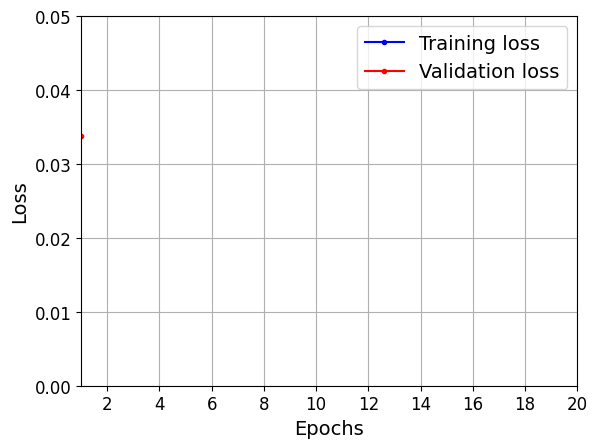

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, 'b.-', label='Training loss')
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, 'r.-', label='Validation loss')
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)


plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 [==============================] - 0s 888us/step


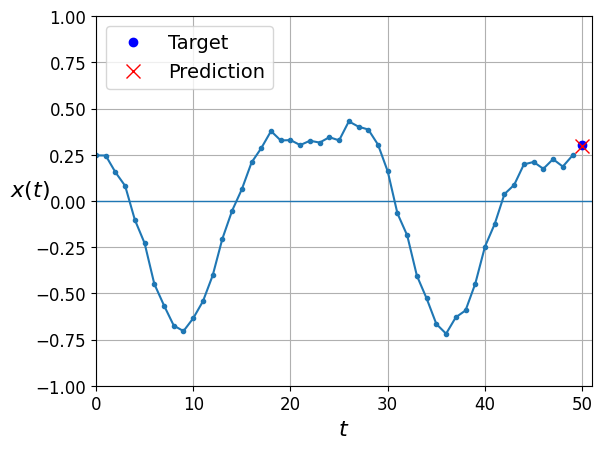

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 간단한 RNN 사용하기

In [12]:
model = keras.models.Sequential([keras.layers.SimpleRNN(1, input_shape=[None, 1])])
optimizer = keras.optimizers.Adam(0.005)
model.compile(optimizer, 'mse')
# history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid))

219/219 [==============================] - 14s 63ms/step - loss: 0.1435 - val_loss: 0.1166


In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 12ms/step - loss: 0.1166


0.11664135754108429

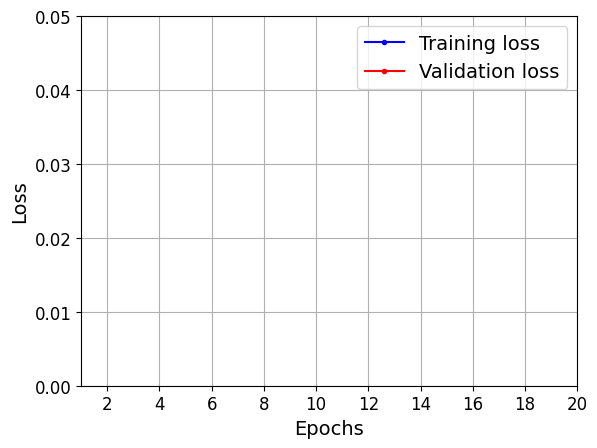

In [14]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 [==============================] - 1s 12ms/step


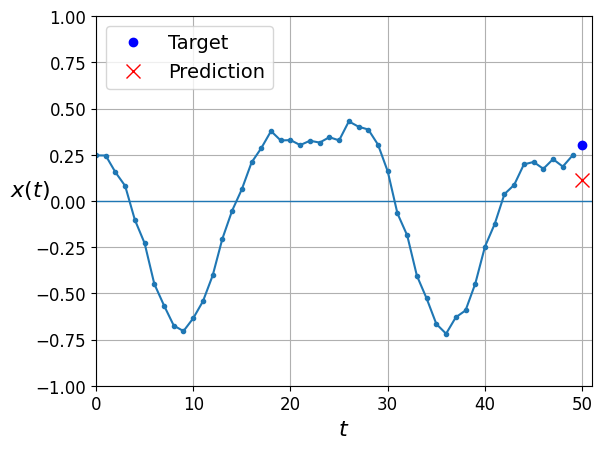

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 심층 RNN

In [16]:
model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20, return_sequences=True),
        keras.layers.SimpleRNN(1)
    ]
)
model.compile('adam', 'mse')
# history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid))

219/219 [==============================] - 49s 217ms/step - loss: 0.0530 - val_loss: 0.0081


In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 2s 32ms/step - loss: 0.0081


0.008059375919401646

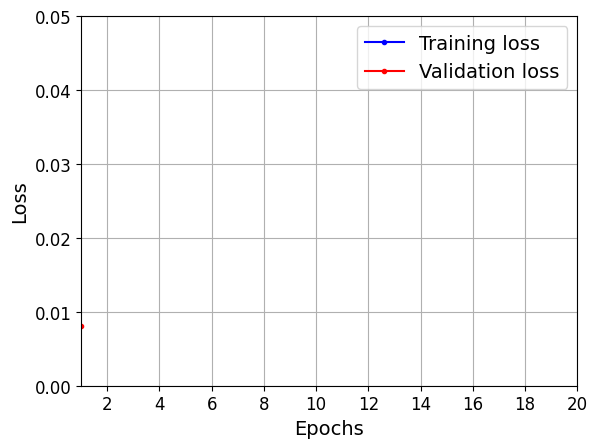

In [18]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 [==============================] - 2s 30ms/step


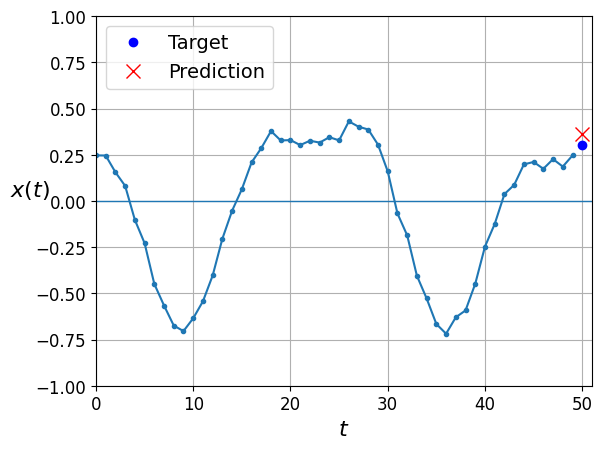

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

두 번째 `SimpleRNN` 층은 마지막 출력만 반환한다:

In [20]:
model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20),
        keras.layers.Dense(1)
    ]
)
model.compile('adam', 'mse')
# history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid))

219/219 [==============================] - 30s 133ms/step - loss: 0.0421 - val_loss: 0.0052


In [21]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 20ms/step - loss: 0.0052


0.005169600713998079

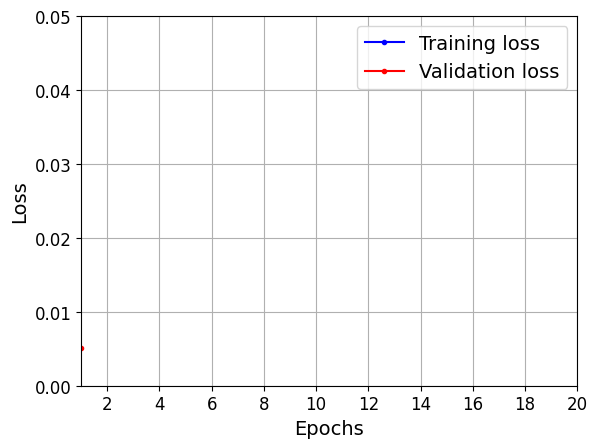

In [22]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

63/63 [==============================] - 1s 20ms/step


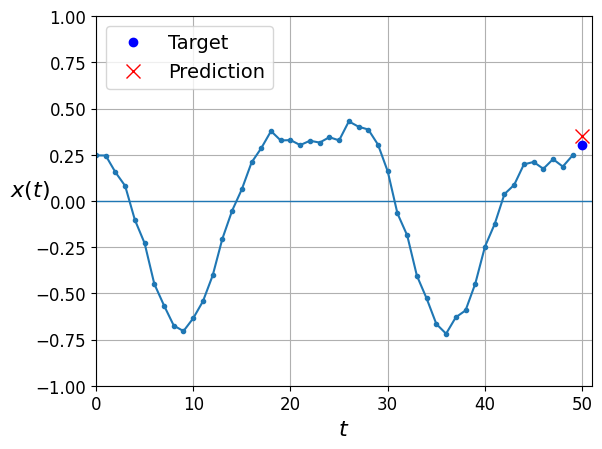

In [23]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 여러 타임 스텝 앞을 예측하기

In [24]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[np.newaxis]
    X = np.concatenate([X, y_pred_one], 1)
Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 36ms/step


In [25]:
Y_pred.shape

(1, 10, 1)

그림 저장 forecast_ahead_plot


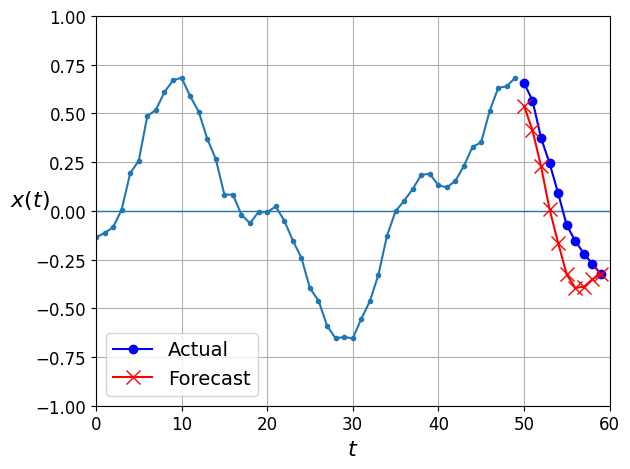

In [26]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], 'bo-', label='Actual')
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], 'rx-', label='Forecast', markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)


plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig('forecast_ahead_plot')
plt.show()

이 모델을 사용해 다음 10개의 값을 예측해 본다. 먼저 아홉 개의 타임 스텝을 더 가진 시퀀스를 다시 생성해야 한다.

In [27]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, n_steps:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, n_steps:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, n_steps:, 0]

이제 하나씩 다음 10개의 값을 예측한다:

In [28]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis]
    X = np.concatenate([X, y_pred_one], 1)
Y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 1s 23ms/step


In [29]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.036439925

이 성능을 단순한 예측이나 간단한 선형 모델과 비교해 본다:

In [30]:
Y_naive_pred = np.tile(X_valid[:, -1], 10)  # 마지막 타임 스텝 값을 선택해 10번 반복한다
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.26119947

In [31]:
model = keras.models.Sequential([keras.layers.Flatten(input_shape=[50, 1]), keras.layers.Dense(10)])
model.compile(loss='mse', optimizer='adam')
# history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid))

219/219 [==============================] - 1s 3ms/step - loss: 0.1584 - val_loss: 0.0656


이제 동시에 다음 10개의 값을 모두 예측하는 RNN을 만들어 본다:

In [32]:
model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20),
        keras.layers.Dense(10)
    ]
)
model.compile('adam', 'mse')
# history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid))

219/219 [==============================] - 35s 152ms/step - loss: 0.0621 - val_loss: 0.0330


In [33]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 0s 214ms/step


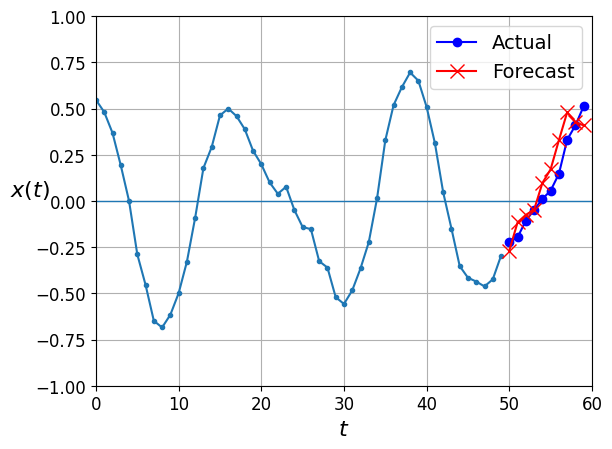

In [34]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

이제 타임 스텝마다 다음 10 스텝을 예측하는 RNN을 만들어 본다. 즉 타임 스텝 0에서 49까지를 기반으로 타임 스텝 50에서 59를 예측하는 것이 아니라, 타임 스텝 0에서 타임 스텝 1에서 10까지 예측하고 그다음 타임 스텝 1에서 타임 스텝 2에서 11까지 예측한다. 마지막 타임 스텝에서는 타임 스텝 50에서 59까지 예측한다. 이 모델은 인과 모델이다. 어떤 타임 스텝에서 예측을 만들 때 과거 타임 스텝만 볼 수 있다.

In [35]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [36]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [37]:
model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ]
)


def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])


model.compile(keras.optimizers.Adam(0.01), 'mse', [last_time_step_mse])
# history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid))

219/219 [==============================] - 30s 130ms/step - loss: 0.0544 - last_time_step_mse: 0.0446 - val_loss: 0.0436 - val_last_time_step_mse: 0.0333


In [38]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 217ms/step


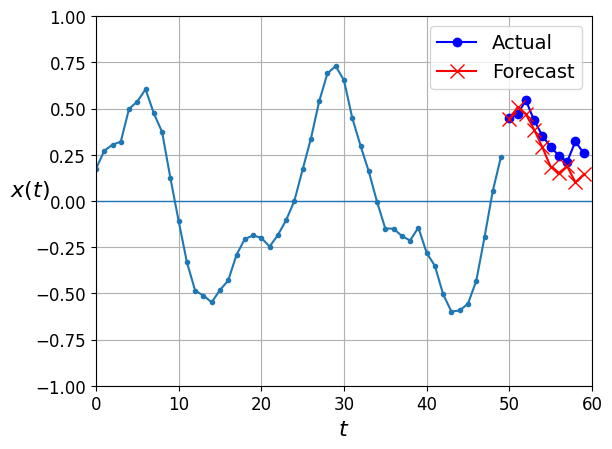

In [39]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# 배치 정규화를 사용한 심층 RNN

In [40]:
model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.BatchNormalization(),
        keras.layers.SimpleRNN(20, return_sequences=True),
        keras.layers.BatchNormalization(),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ]
)
model.compile('adam', 'mse', [last_time_step_mse])
# history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid))

219/219 [==============================] - 30s 131ms/step - loss: 0.1609 - last_time_step_mse: 0.1594 - val_loss: 0.0763 - val_last_time_step_mse: 0.0699


# 층 정규화를 사용한 심층 RNN

In [41]:
from tensorflow.keras.layers import LayerNormalization

In [42]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units, None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)

    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype)]

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [43]:
model = keras.models.Sequential(
    [
        keras.layers.RNN(LNSimpleRNNCell(20), True, input_shape=[None, 1]),
        keras.layers.RNN(LNSimpleRNNCell(20), True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ]
)
model.compile('adam', 'mse', [last_time_step_mse])
# history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid))

219/219 [==============================] - 61s 244ms/step - loss: 0.1186 - last_time_step_mse: 0.1131 - val_loss: 0.0632 - val_last_time_step_mse: 0.0543


# 사용자 정의 RNN 클래스 만들기

In [44]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(self.cell, 'get_initial_state', self.fallback_initial_state)

    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], inputs.dtype)]

    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(inputs.dtype, (n_steps if self.return_sequences else 0))
        outputs = tf.zeros([batch_size, self.cell.output_size], inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [45]:
model = keras.models.Sequential(
    [
        MyRNN(LNSimpleRNNCell(20), True, input_shape=[None, 1]),
        MyRNN(LNSimpleRNNCell(20), True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ]
)
model.compile('adam', 'mse', [last_time_step_mse])
# history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid))

219/219 [==============================] - 58s 257ms/step - loss: 0.1359 - last_time_step_mse: 0.1306 - val_loss: 0.0715 - val_last_time_step_mse: 0.0646


In [46]:
model = keras.models.Sequential(
    [
        keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.LSTM(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ]
)
model.compile('adam', 'mse', [last_time_step_mse])
# history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid))

219/219 [==============================] - 11s 20ms/step - loss: 0.0752 - last_time_step_mse: 0.0605 - val_loss: 0.0527 - val_last_time_step_mse: 0.0311


In [47]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0527 - last_time_step_mse: 0.0311


[0.05272330343723297, 0.031132137402892113]

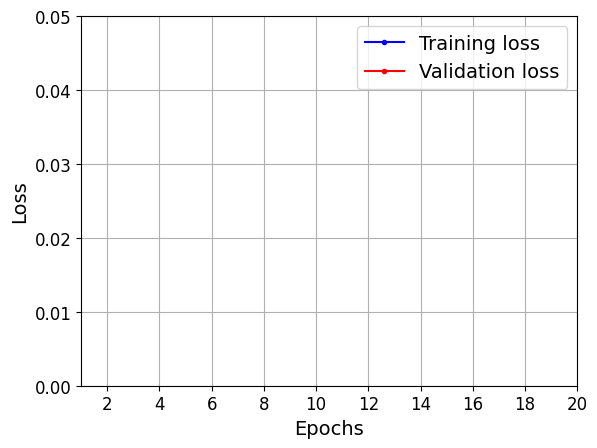

In [48]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

In [49]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 1s 576ms/step


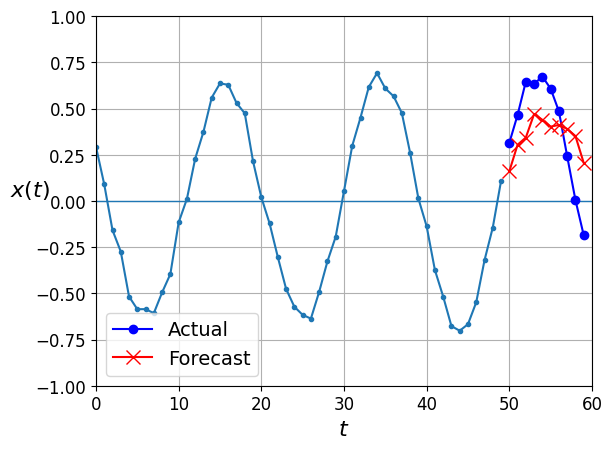

In [50]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRU

In [51]:
model = keras.models.Sequential(
    [
        keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.GRU(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ]
)
model.compile('adam', 'mse', [last_time_step_mse])
# history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid))

219/219 [==============================] - 6s 18ms/step - loss: 0.0778 - last_time_step_mse: 0.0691 - val_loss: 0.0552 - val_last_time_step_mse: 0.0439


In [52]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 7ms/step - loss: 0.0552 - last_time_step_mse: 0.0439


[0.05517812818288803, 0.04394255205988884]

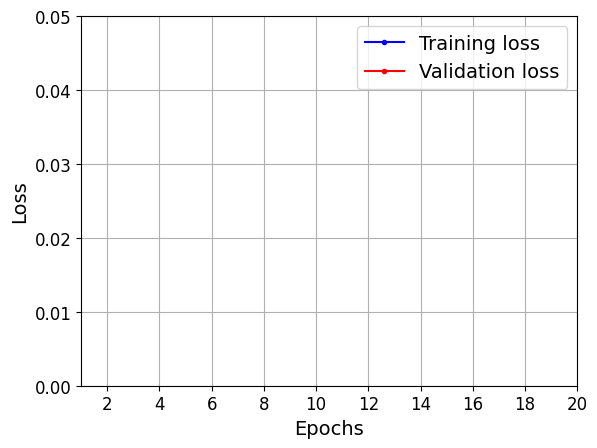

In [53]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])
plt.show()

In [54]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 1s 511ms/step


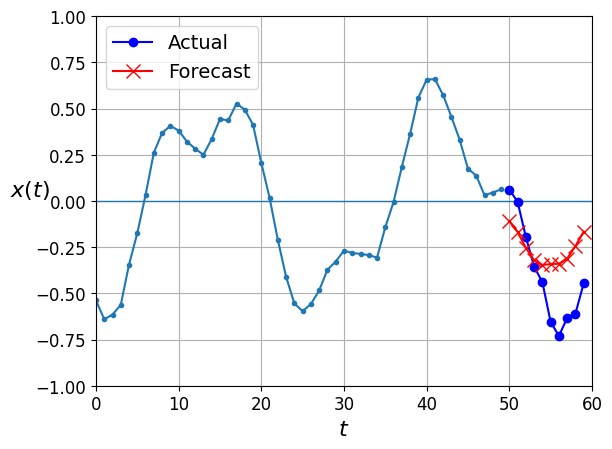

In [55]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [56]:
model = keras.models.Sequential(
    [
        keras.layers.Conv1D(20, 4, 2, input_shape=[None, 1]),
        keras.layers.GRU(20, return_sequences=True),
        keras.layers.GRU(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(10))
    ]
)
model.compile('adam', 'mse', [last_time_step_mse])
# history = model.fit(X_train, Y_train[:, 3::2], epochs=20, validation_data=(X_valid, Y_valid[:, 3::2]))
history = model.fit(X_train, Y_train[:, 3::2], validation_data=(X_valid, Y_valid[:, 3::2]))

219/219 [==============================] - 9s 15ms/step - loss: 0.0695 - last_time_step_mse: 0.0622 - val_loss: 0.0443 - val_last_time_step_mse: 0.0365


## WaveNet

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [57]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer([None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(20, 2, padding='causal', activation='relu', dilation_rate=rate))
model.add(keras.layers.Conv1D(10, 1))
model.compile('adam', 'mse', [last_time_step_mse])
# history = model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid))

219/219 [==============================] - 4s 12ms/step - loss: 0.0662 - last_time_step_mse: 0.0551 - val_loss: 0.0353 - val_last_time_step_mse: 0.0210


다음은 논문에 정의된 원본 WaveNet이다. ReLU 대신에 GatedActivationUnit과 스킵 연결을 사용한다. 또한 점점 더 시퀀스가 짧아지는 것을 피하기 위해 왼쪽에 0으로 패딩한다:

In [58]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [59]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, 2, padding='causal', dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, 1)(z)
    return keras.layers.Add()([z, inputs]), z

In [60]:
n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 10  # 256 in the paper
inputs = keras.layers.Input([None, 1])
z = keras.layers.Conv1D(n_filters, 2, padding='causal')(inputs)
skip_to_last = []
for dilation_rate in [2 ** i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, 1, activation='relu')(z)
Y_proba = keras.layers.Conv1D(n_outputs, 1, activation='softmax')(z)
model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [61]:
model.compile('adam', 'mse', [last_time_step_mse])
# history = model.fit(X_train, Y_train, epochs=2, validation_data=(X_valid, Y_valid))
history = model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid))

219/219 [==============================] - 4s 14ms/step - loss: 0.1284 - last_time_step_mse: 0.1248 - val_loss: 0.1229 - val_last_time_step_mse: 0.1173


이 장에서 RNN의 기초 사항을 살펴보았고 RNN을 사용해 시퀀스(소위 시계열)을 처리했다. CNN을 포함하여 시퀀스를 처리하는 다른 방법도 알아보았다. 다음에는 RNN을 자연어 처리에 적용해 보겠다. 그리고 RNN에 대해 더 자세히 배워 보겠다(양방향 RNN, 상태가 있는 RNN과 상태가 없는 RNN, 인코더-디코더, 어텐션을 사용한 인코더-디코더). 또한 어텐션만 사용하는 구조인 트랜스포머도 살펴보겠다.

# 연습

## 1. SketchRNN 데이터셋 다루기

_연습: 텐서플로 데이터셋에서 제공하는 SketchRNN 데이터셋으로 분류 모델을 훈련해 본다._

이 데이터셋은 아직 TFDS에서 제공하지 않는다. 아직 [풀 리퀘스트](https://github.com/tensorflow/datasets/pull/361)가 진행 중이다. 다행히 이 데이터는 TFRecord로 제공되므로 다운로드해 본다(3,450,000 훈련 스케치와 345,000 테스트 스케치가 포함된 이 데이터셋은 1GB 정도되기 때문에 다운로드 시간이 조금 걸린다):

In [62]:
DOWNLOAD_ROOT = 'http://download.tensorflow.org/data/'
FILENAME = 'quickdraw_tutorial_dataset_v1.tar.gz'
filepath = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, cache_subdir='datasets/quickdraw', extract=True)

In [63]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob('training.tfrecord-*')])
eval_files = sorted([str(path) for path in quickdraw_dir.glob('eval.tfrecord-*')])

In [64]:
train_files

['C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\training.tfrecord-00000-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\training.tfrecord-00001-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\training.tfrecord-00002-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\training.tfrecord-00003-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\training.tfrecord-00004-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\training.tfrecord-00005-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\training.tfrecord-00006-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\training.tfrecord-00007-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\training.tfrecord-00008-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\training.tfrecord-00009-of-00010']

In [65]:
eval_files

['C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\eval.tfrecord-00000-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\eval.tfrecord-00001-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\eval.tfrecord-00002-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\eval.tfrecord-00003-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\eval.tfrecord-00004-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\eval.tfrecord-00005-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\eval.tfrecord-00006-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\eval.tfrecord-00007-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\eval.tfrecord-00008-of-00010',
 'C:\\Users\\kyun\\.keras\\datasets\\quickdraw\\eval.tfrecord-00009-of-00010']

In [66]:
with open(quickdraw_dir / 'eval.tfrecord.classes') as test_classes_file:
    test_classes = test_classes_file.readlines()
with open(quickdraw_dir / 'training.tfrecord.classes') as train_classes_file:
    train_classes = train_classes_file.readlines()

In [67]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [68]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [69]:
def parse(data_batch):
    feature_descriptions = {
        'ink': tf.io.VarLenFeature(tf.float32),
        'shape': tf.io.FixedLenFeature([2], tf.int64),
        'class_index': tf.io.FixedLenFeature([1], tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples['ink'])
    sketches = tf.reshape(flat_sketches, [tf.size(data_batch), -1, 3])
    lengths = examples['shape'][:, 0]
    labels = examples['class_index'][:, 0]
    return sketches, lengths, labels

In [70]:
AUTOTUNE = tf.data.AUTOTUNE


def quickdraw_dataset(
        filepaths,
        batch_size=32,
        shuffle_buffer_size=None,
        n_parse_threads=AUTOTUNE,
        n_read_threads=AUTOTUNE,
        cache=False
):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, n_parse_threads)
    return dataset.prefetch(AUTOTUNE)

In [71]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [72]:
for sketches, lengths, labels in train_set.take(1):
    print(f'sketches = {sketches}')
    print(f'lengths = {lengths}')
    print(f'labels = {labels}')

sketches = [[[-0.09777778 -0.04330707  0.        ]
  [-0.1022222  -0.01181105  0.        ]
  [-0.07999998  0.01181105  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.18823531 -0.02380952  0.        ]
  [-0.09411764  0.03571429  0.        ]
  [-0.10196079  0.07142857  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.07843138 -0.07182321  0.        ]
  [-0.04705882 -0.08287293  0.        ]
  [-0.05098039 -0.14917126  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.00934577 -0.06274511  0.        ]
  [ 0.02803737 -0.07058824  0.        ]
  [ 0.05607477 -0.05882353  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.   

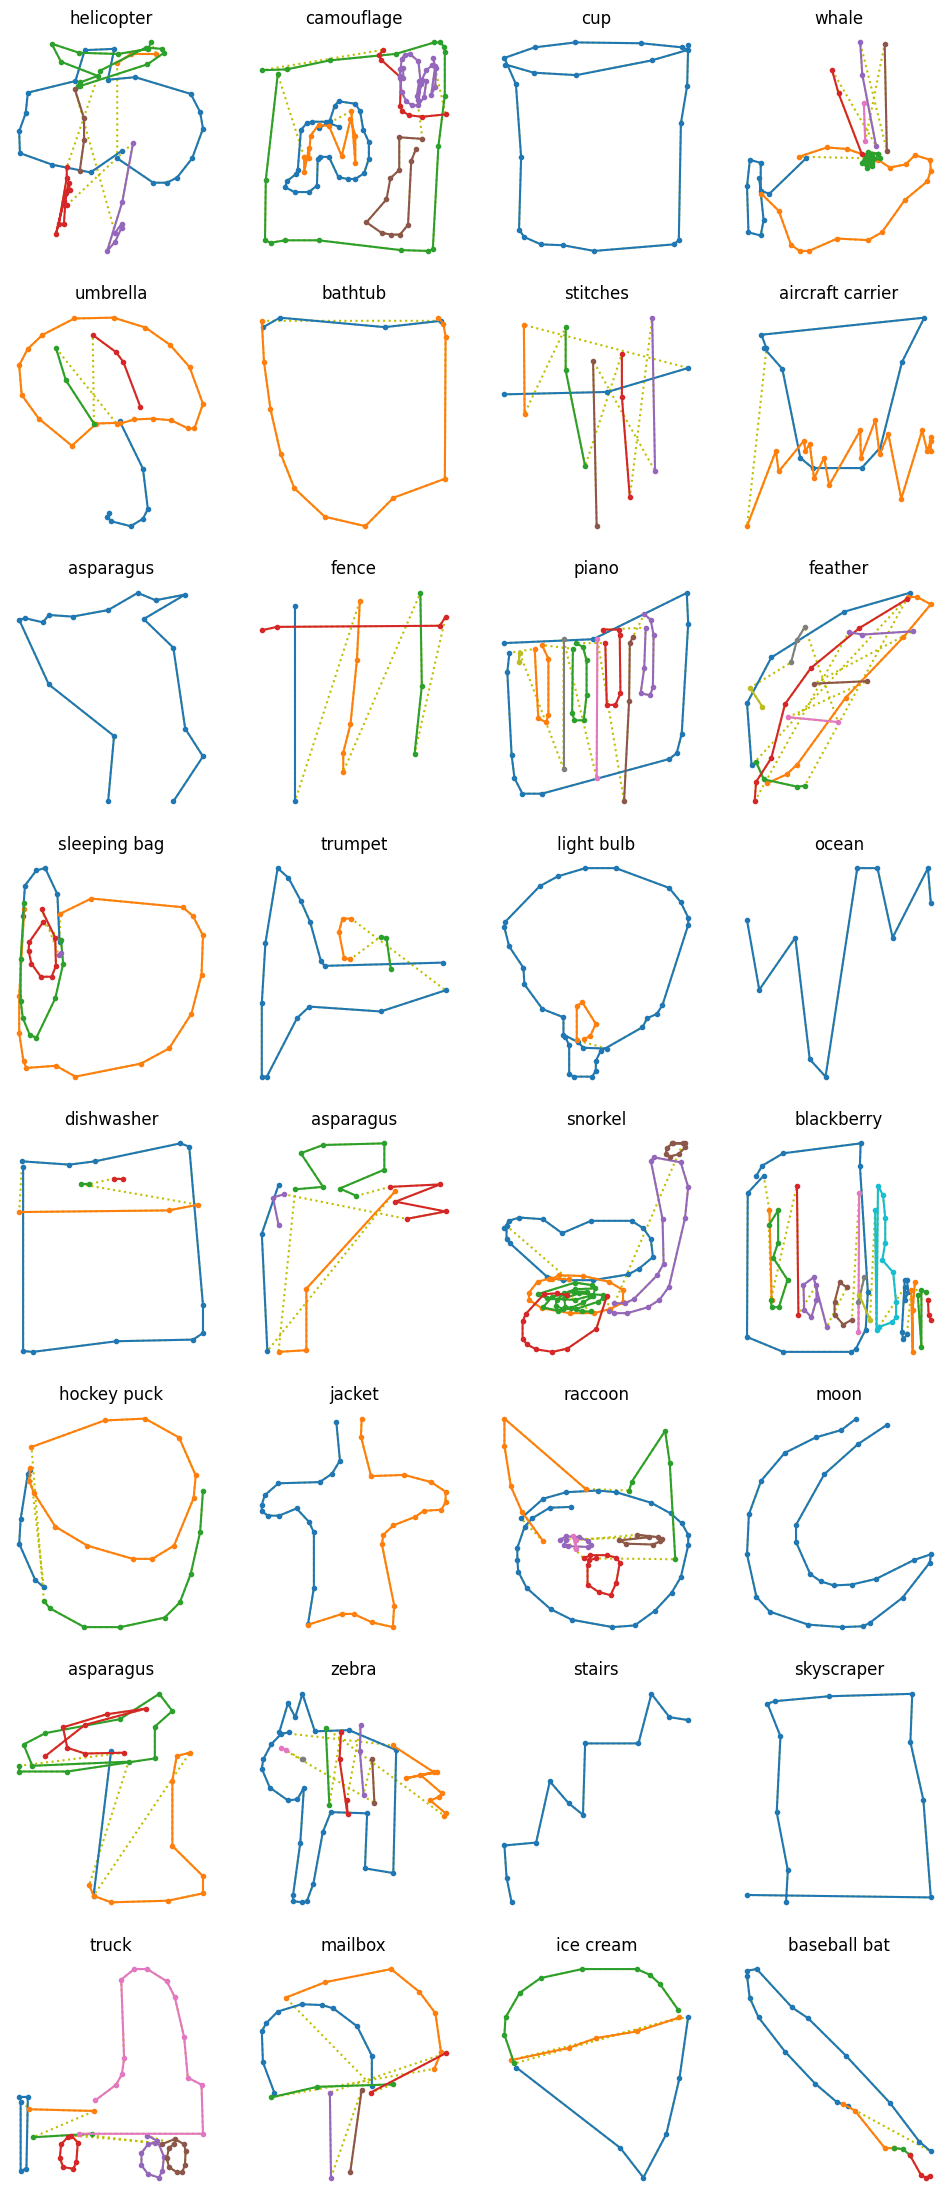

In [73]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1] == 1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else 'Try to guess'
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], 'y:')
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], '.-')
    plt.axis('off')


def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()


for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

대부분의 스케치는 100개 포인트 이하로 구성되어 있다:

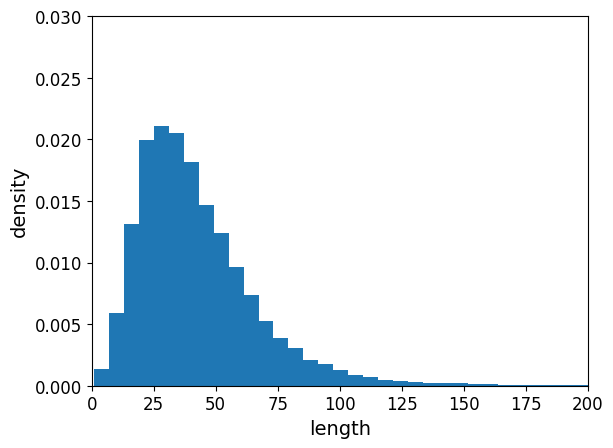

In [74]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, 150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel('length')
plt.ylabel('density')
plt.show()

In [75]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))


cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [76]:
model = keras.models.Sequential(
    [
        keras.layers.Conv1D(32, 5, 2, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(64, 5, 2, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Conv1D(128, 3, 2, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.LSTM(128, return_sequences=True),
        keras.layers.LSTM(128),
        keras.layers.Dense(len(class_names), 'softmax')
    ]
)
optimizer = keras.optimizers.SGD(clipnorm=1.)
model.compile(optimizer, 'sparse_categorical_crossentropy', ['accuracy', 'sparse_top_k_categorical_accuracy'])
# history = model.fit(cropped_train_set, epochs=2, validation_data=cropped_valid_set)
history = model.fit(cropped_train_set, validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 2219s 21ms/step - loss: 4.1200 - accuracy: 0.1636 - sparse_top_k_categorical_accuracy: 0.3652 - val_loss: 3.0701 - val_accuracy: 0.3121 - val_sparse_top_k_categorical_accuracy: 0.5956
Epoch 2/2
107813/107813 [==============================] - 2173s 20ms/step - loss: 2.7121 - accuracy: 0.3781 - sparse_top_k_categorical_accuracy: 0.6673 - val_loss: 2.5103 - val_accuracy: 0.4146 - val_sparse_top_k_categorical_accuracy: 0.7027


In [77]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

5392/5392 [==============================] - 35s 6ms/step


In [78]:
np.mean(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.59654087

1/1 [==============================] - 1s 677ms/step


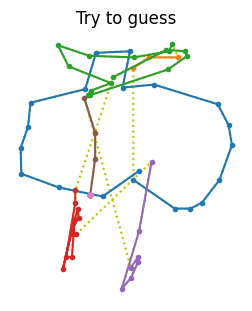

Top-5 predictions: 1
  1. fan 15.368%
  2. sea turtle 8.477%
  3. helicopter 7.153%
  4. bird 4.982%
  5. parrot 4.894%
Answer: helicopter


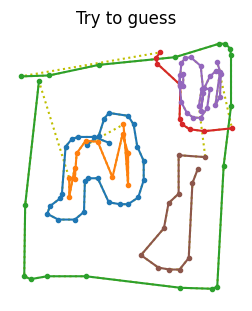

Top-5 predictions: 2
  1. the mona lisa 31.657%
  2. map 8.673%
  3. passport 8.125%
  4. stove 5.540%
  5. calendar 3.684%
Answer: camouflage


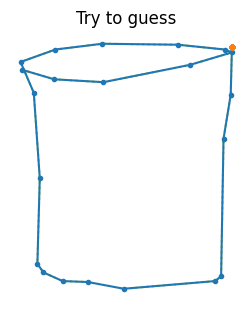

Top-5 predictions: 3
  1. cup 50.295%
  2. paint can 13.557%
  3. mug 13.438%
  4. bucket 3.632%
  5. coffee cup 2.915%
Answer: cup


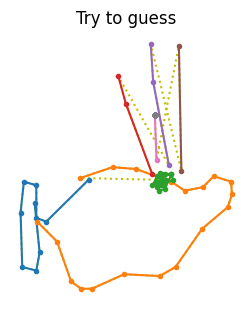

Top-5 predictions: 4
  1. whale 12.572%
  2. trumpet 4.603%
  3. scorpion 4.583%
  4. helicopter 4.341%
  5. snorkel 3.895%
Answer: whale


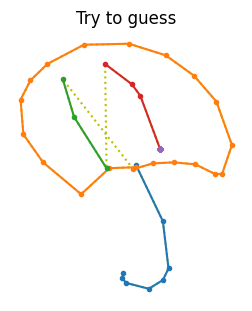

Top-5 predictions: 5
  1. hot air balloon 31.488%
  2. mushroom 23.543%
  3. light bulb 11.064%
  4. microphone 5.498%
  5. popsicle 4.318%
Answer: umbrella


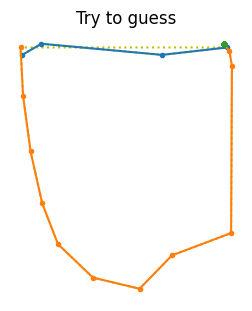

Top-5 predictions: 6
  1. underwear 30.550%
  2. canoe 8.144%
  3. diamond 7.053%
  4. cup 5.711%
  5. hexagon 5.258%
Answer: bathtub


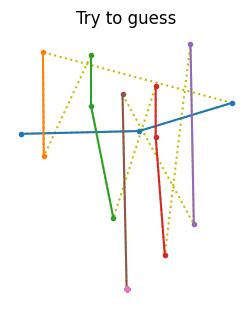

Top-5 predictions: 7
  1. stitches 42.839%
  2. fence 15.950%
  3. jail 10.117%
  4. bridge 5.157%
  5. grass 4.185%
Answer: stitches


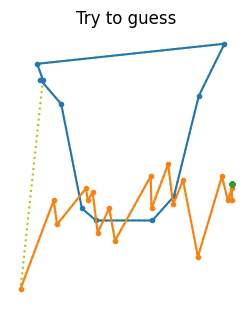

Top-5 predictions: 8
  1. saw 27.239%
  2. the great wall of china 19.871%
  3. bottlecap 14.857%
  4. arm 3.166%
  5. beach 2.796%
Answer: aircraft carrier


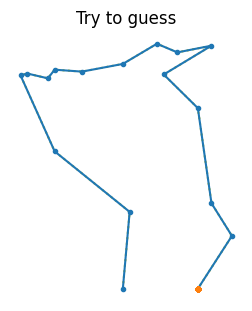

Top-5 predictions: 9
  1. streetlight 23.708%
  2. nail 7.708%
  3. spoon 6.491%
  4. finger 6.289%
  5. asparagus 5.889%
Answer: asparagus


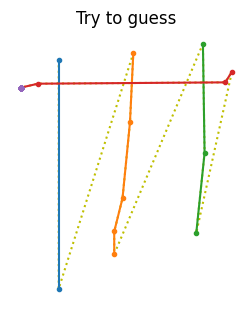

Top-5 predictions: 10
  1. table 24.163%
  2. swing set 18.770%
  3. jail 14.731%
  4. bench 9.075%
  5. fence 6.769%
Answer: fence


In [79]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, 5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print(f'Top-5 predictions: {index + 1}')
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print(f'  {k + 1}. {class_name} {proba:.3f}%')
    print(f'Answer: {class_names[labels[index].numpy()]}')

In [92]:
model.save('my_sketchrnn')

INFO:tensorflow:Assets written to: my_sketchrnn\assets


INFO:tensorflow:Assets written to: my_sketchrnn\assets


## 2. 바흐 합창곡

_연습: [바흐 합창곡](https://homl.info/bach) 데이터셋을 다운로드하여 압축을 푼다. 이 데이터셋은 요한 제바스티안 바흐가 작곡한 382개의 합창곡으로 구성되어 있다. 각 곡은 100에서 640까지 타임 스텝 길이이다. 각 타임 스텝은 4개의 정수를 담고 있다. 각 정수는 피아노 음표의 인덱스에 해당한다(연주되는 음표가 없다는 것을 의미하는 0은 제외). 코랄의 타임 스텝 시퀀스가 주어지면 다음 타임 스텝(4개의 음표)을 예측할 수 있는 순환 모델, 합성곱 모델 또는 두 가지를 합친 모델을 훈련한다. 그다음 이 모델을 사용해 한 번에 하나의 음표씩 바흐와 같은 음악을 생성한다. 코랄의 시작 부분을 모델에 주입하고 다음 타임 스텝을 예측한다. 이 타임 스텝을 입력 시퀀스에 추가하여 모델이 다음 음표를 예측하게 만드는 식이다. 또 바흐를 위한 [구글 두들](https://www.google.com/doodles/celebrating-johann-sebastian-bach)에 사용한 구글의 [Coconet 모델](https://homl.info/coconet)을 확인해 본다._

In [93]:
DOWNLOAD_ROOT = 'https://github.com/ageron/handson-ml2/raw/master/datasets/jsb_chorales/'
FILENAME = 'jsb_chorales.tgz'
filepath = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, cache_subdir='datasets/jsb_chorales', extract=True)

117661/117661 [==============================] - 0s 1us/step


In [99]:
jsb_chorales_dir = Path(filepath).parent
train_files = sorted(jsb_chorales_dir.glob('train/chorale_*.csv'))
valid_files = sorted(jsb_chorales_dir.glob('valid/chorale_*.csv'))
test_files = sorted(jsb_chorales_dir.glob('test/chorale_*.csv'))

In [103]:
import pandas as pd


def load_chorales(filepaths):
    return [pd.read_csv(filepath).values.tolist() for filepath in filepaths]


train_chorales = load_chorales(train_files)
valid_chorales = load_chorales(valid_files)
test_chorales = load_chorales(test_files)

In [108]:
train_chorales[0]

[[74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [74, 70, 65, 58],
 [75, 70, 58, 55],
 [75, 70, 58, 55],
 [75, 70, 60, 55],
 [75, 70, 60, 55],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 69, 62, 50],
 [77, 70, 62, 55],
 [77, 70, 62, 55],
 [77, 69, 62, 55],
 [77, 69, 62, 55],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [72, 69, 65, 53],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [74, 70, 65, 46],
 [75, 69, 63, 48],
 [75, 69, 63, 48],
 [75, 67, 63, 48],
 [75, 67, 63, 48],
 [77, 65, 62, 50],
 [77, 65, 62, 50],
 [77, 65, 60, 50],
 [77, 65, 60, 50],
 [74, 67, 58, 55],
 [74, 67, 58, 55],
 [74, 67, 58, 53],
 [74, 67, 58, 53],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 67, 58, 51],
 [72, 65, 57

음표의 범위는 36(C1 = 옥타브 1의 C)에서 81(A5 = 옥타브 5의 A)까지이고 무음을 위해 0을 추가한다: